# Machine Learning Model for Predicting Wins

In this notebook, we use the data that we have gathered to fit a machine learning model to our data. We want to see how our model compares to the Pythagorean expectation. We will first analyze what model best fits our data. Then we will see if any of our variables will lower our test error if we remove them. Finally, we will feed our model training data and have it predict on test data. We will then calculate the Pythagorean expectation for that test error, then see if our model come close in accuracy.

In [1]:
import numpy as np
import pandas as pd
import requests
import plotly.offline as py
import matplotlib.pyplot as plt
from plotly.graph_objs import *
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
%matplotlib inline
pd.set_option("max_r", 15)
py.init_notebook_mode(connected=True)

In [2]:
training = pd.read_csv("training.csv")
# Calculate the run differential to be passed into our models.
training["Rdiff"] = training["R"] - training["RA"]
r = training['R']
ra = training['RA']
year = training["year"]
training = training.drop(['R', "RA"], axis=1)
# Grab the wins (y) variable and then drop it from the dataframe (X).
y = training['W']
training = training.drop('W', axis=1)

In [3]:
# Year needs to be classified as a categorical variable.
X = pd.get_dummies(training["year"]).drop(1996, axis=1)
training = pd.concat([training, X], axis=1).drop("year",axis=1)
training.head()

,SOS,ERA,WHIP,FIP,SO,Rdiff,1997,1998,1999,2000,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,0.0,4.52,1.451,4.83,1050,32.4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,4.49,1.462,4.51,1091,16.2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.2,4.79,1.464,4.94,877,-113.4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.1,5.00,1.517,5.46,846,-16.2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.2,4.20,1.375,4.48,947,-32.4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Model 1: Linear regression

In [4]:
model = LinearRegression()
-cross_val_score(model, X=training, y=y, cv=10, scoring="neg_mean_squared_error").mean()

17.528770245915684

Model 2: Polynomial regression

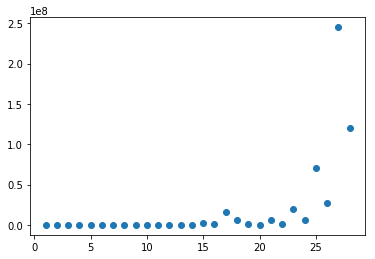

In [5]:
# Determine which polynomial model is the best.
df = training.copy()
model = LinearRegression()
cross_val = []
Rdiffs = []
for i in range (2, 30):
    df["Rdiff^%s" % i] = df["Rdiff"] ** i
    Rdiffs.append("Rdiff^%s" % i)
    cross_val.append(-cross_val_score(model, df[Rdiffs], y, cv=10, scoring="neg_mean_squared_error").mean())
    
cross_val = pd.DataFrame(cross_val, columns=["cross_val_score"]) 
cross_val["pow"] = cross_val.index+1
plt.scatter(cross_val["pow"], cross_val["cross_val_score"])

In the graph above, we plot the cross value score for powers 1 through 30 in order to see which polynomial model minimize the test errror best.

In [6]:
cross_val.min()

cross_val_score    60.749717
pow                 1.000000
dtype: float64

In [7]:
cross_val[cross_val["cross_val_score"] == cross_val["cross_val_score"].min()]

,cross_val_score,pow
3,60.749717,4


Model 3: K-Nearest Neighbors

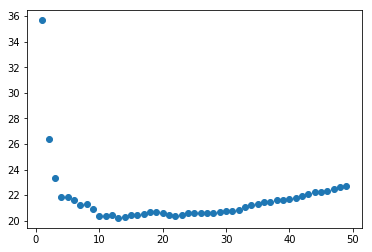

In [8]:
cross_val = []
n_neighbors = []
for i in range (1, 50):
    model = KNeighborsRegressor(n_neighbors=i)
    n_neighbors.append(i)
    cross_val.append(-cross_val_score(model, training, y, cv=10, scoring="neg_mean_squared_error").mean())
    
cross_val = pd.DataFrame(cross_val, columns=["cross_val_score"]) 
cross_val["n_neighbors"] = cross_val.index+1
plt.scatter(cross_val["n_neighbors"], cross_val["cross_val_score"])

The graph above helps us determine the amount of neighbors that best fits the model to our data

In [9]:
cross_val.min()

cross_val_score    20.226727
n_neighbors         1.000000
dtype: float64

In [10]:
cross_val[cross_val["cross_val_score"] == cross_val["cross_val_score"].min()]

,cross_val_score,n_neighbors
12,20.226727,13


Model 4: Decision Tree

In [11]:
model = tree.DecisionTreeRegressor()
-cross_val_score(model, X=training, y=y, cv=10, scoring="neg_mean_squared_error").mean()

39.215745007680496

Model 5: Random Forest

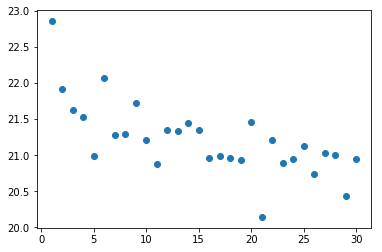

In [12]:
cross_val = []
n_estimators = []
for i in range (10, 40):
    model = RandomForestRegressor(n_estimators=i)
    n_estimators.append(i)
    cross_val.append(-cross_val_score(model, training, y, cv=10, scoring="neg_mean_squared_error").mean())
    
cross_val = pd.DataFrame(cross_val, columns=["cross_val_score"]) 
cross_val["n_estimators"] = cross_val.index+1
plt.scatter(cross_val["n_estimators"], cross_val["cross_val_score"])

The graph above helps us determine the best amount of estimators for our model

In [13]:
cross_val.min()

cross_val_score    20.144058
n_estimators        1.000000
dtype: float64

In [14]:
cross_val[cross_val["cross_val_score"] == cross_val["cross_val_score"].min()]

,cross_val_score,n_estimators
20,20.144058,21


Now that we have examined various models, we can safely conclude that the best model for this data is linear regresssion.

Here we are testing our best model with different combinations of variables.

In [15]:
# Dropping strikeouts improves our score by .02
model = LinearRegression()
-cross_val_score(model, X=training.drop("SO",axis=1), y=y, cv=10, scoring="neg_mean_squared_error").mean()

17.472625817114366

In [16]:
# Dropping strikeouts and strength of schedule.
model = LinearRegression()
-cross_val_score(model, X=training.drop(["SO","SOS"],axis=1), y=y, cv=10, scoring="neg_mean_squared_error").mean()

17.385170574685219

In [17]:
# Dropping strikeouts, strength of schedule, and WHIP.
model = LinearRegression()
-cross_val_score(model, X=training.drop(["SO","SOS","WHIP"],axis=1), y=y, cv=10, scoring="neg_mean_squared_error").mean()

17.382107165558104

In [18]:
# Dropping strikeouts, strength of schedule, WHIP, ERA.
model = LinearRegression()
-cross_val_score(model, X=training.drop(["SO","SOS","WHIP","ERA"],axis=1), y=y, cv=10, scoring="neg_mean_squared_error").mean()

17.292438000122736

In [19]:
# Dropping strikeouts, strength of schedule, WHIP, ERA, and FIP.
# This worsens our model.
model = LinearRegression()
-cross_val_score(model, X=training.drop(["SO","SOS","WHIP","ERA","FIP"],axis=1), y=y, cv=10, scoring="neg_mean_squared_error").mean()

17.835073004006638

Thus, we conclude that the Linear Regression model utilizing Fielding-Independent Pitching, Run Differential, and the year is our best regression model based on our calculated cross val scores.

In [20]:
# Correct training dataframe to include only the variables that make the best model.
training = training.drop(["SO","SOS","WHIP","ERA"], axis=1)
training.head()

,FIP,Rdiff,1997,1998,1999,2000,2001,2002,2003,2004,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,4.83,32.4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.51,16.2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.94,-113.4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.46,-16.2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.48,-32.4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Predicting wins using our new model:

In [21]:
# in order to calcualte pythagorean expectation
def calc_win_ratio(r, ra):
    return (r**2) / (r**2 + ra**2)

In [22]:
df = pd.DataFrame()
y_resids = []
pythep_resids = []
pred = pd.Series()
y_test = pd.Series()

# Simulate calculations 100 times so we can get long-run averages for residuals.
for i in range(1,101):
    # Randomly split data into training and test sets.
    X_train, X_test, y_train, y_test = train_test_split(training, y, test_size=300)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
    
    y_resid = abs(y_test.values - y_predicted)
    
    ra_test = ra[X_test.index]
    r_test = r[X_test.index]
    
    X_test = pd.DataFrame(X_test)
    X_test["pythep"] = calc_win_ratio(r_test, ra_test) * 162
    X_test["year"] = year[X_test.index]
    
    # Get one point from each year in the data set, so we can make a plot.
    years = []
    indicies = []
    for i in X_test.index:
        if X_test.loc[i, "year"] not in years:
            years.append(X_test.loc[i, "year"])
            indicies.append(i)
            
    years = list(set(years))
    df = pd.DataFrame(X_test.loc[indicies])
    df = df.sort_values(by="year")
    
    pred = pd.Series(y_predicted, index=X_test.index)
    
    y_resids.append(abs(y_test[df.index] - pred[df.index]).sum())
    pythep_resids.append(abs(y_test[df.index] - df["pythep"]).sum())

In [23]:
np.mean(y_resids), np.mean(pythep_resids)

(70.152124003727124, 67.240972387475225)

In [24]:
# Plotly: plot actual wins, Pythagorean Expectation predicted wins, and our predicted wins.
trace0 = Scatter(
    x = df['year'],
    y = y_test[df.index],
    name = "Actual Wins",
    line = dict(
        color = ('rgb(0,0,0)')
    )
)
trace1 = Scatter(
    x = df['year'],
    y = df["pythep"],
    name = "Pythagorean Expectation",
    line = dict(
        color = ('rgb(0,0,255)')
    )
)
trace2 = Scatter(
    x = df['year'],
    y = pred[df.index],
    name = "Our Prediction",
    line = dict(
        color = ('rgb(255,0,0)')
    )
)

traces = [trace0, trace1, trace2]

layout = dict(
    title = "Comparing Our Model to Pythagorean Expectation",
    xaxis = dict(title = "Year"),
    yaxis = dict(title = "Number of Wins")
)

fig = dict(data=traces, layout=layout)
py.iplot(fig)

Our residual sizes are always very close to those that the Pythagorean Expectation produces. Machine learning does prove to be helpful for predicting baseball wins.